# IO


In [ ]:
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wxderivs import (
    DIR_WORK,
    MONTH_CDD,
    MONTH_HDD,
    NUM_SIM,
    SET_CDD,
    SET_HDD,
    SET_USA,
    EllipticalCop,
    dct_name_file,
    get_gen_idx_cv,
    get_joint_test_stat_cv,
    get_sim,
    get_VaR_ES_portfolio,
    make_cdf_ppf,
)

0 Las Vegas Mccarran Airport
1 LONDON HEATHROW
2 Dallas-Fort Worth International Airport
3 ESSEN
4 New York LaGuardia Airport
5 Cincinnati-Northern Kentucky International Airport
6 Boston-Logan International Airport
7 Portland International Airport
8 PARIS ORLY
9 Chicago OHare International Airport
10 Minneapolis-Saint Paul International Airport
11 Atlanta-Hartsfield International Airport
12 Houston-George Bush Intercontinental Airport
13 Burbank-Glendale-Pasadena Airport
14 TOKYO
15 AMSTERDAM SCHIPHOL
16 Philadelphia International Airport
17 Sacramento Executive Airport


In [2]:
file_in = DIR_WORK / "out" / "res_CDD_HDD.pkl"
with open(file_in, "rb") as f:
    data_in = pickle.load(f)
pprint(list(data_in.keys()))
dct_fit_res = data_in["dct_fit_res"]
df_y = data_in["df_y"]
df_y_pred = data_in["df_y_pred"]
df_res = data_in["df_res"]
df_std = data_in["df_std"]
df_res_scaled = data_in["df_res_scaled"]

['df_avg_all',
 'df_max_all',
 'df_min_all',
 'dct_fit_res',
 'df_y',
 'df_y_pred',
 'df_res',
 'df_std',
 'df_res_scaled',
 'df_cdd',
 'df_cdd_pred',
 'df_cdd_res',
 'df_hdd',
 'df_hdd_pred',
 'df_hdd_res',
 'df_evi_all']


> `df_res_scaled`: $\frac{T-T_{pred}}{std_{res}}$ for us to model and compare tail risk metrics; notice models are built on this (scaled) raw temperature residuals, rather than CDD/HDD residuals;
>
> Assuming equal weight portfolio.

- model $T$ residuals, in CDD/HDD months, separately
- model candidates (all of non-parametric margin, which can be shared)
  - Gaussian cop
  - Student's t cop
  - vine cop
- metrics to compare
  - scoring function-based VaR-ES joint test
    - test stat is Z-score, null hypothesis is to accept the model
  - Deng, K. and Qiu, J., 2021. Backtesting expected shortfall and beyond. Quantitative Finance, 21(7), pp.1109-1125.
    - equation 23
  - using 10-fold cross validation


- Eq. 22

```python
alpha * (srs_VaR_portfolio - srs_ES_portfolio) + (
  srs_test_portfolio - srs_VaR_portfolio
).clip(None, 0)
```

- Eq. 23

```python
(
  (srs_test_portfolio - srs_VaR_portfolio).clip(None, 0)
  / (srs_VaR_portfolio - srs_ES_portfolio)
).mean().item() / alpha + 1
```


# CDD scaled res

> assuming equal long weight portfolio
> only days in CDD months


In [3]:
# ! only those days in CDD months
idx_all = df_y.index[df_y.index.month.isin(MONTH_CDD)]
# * CV
gen = get_gen_idx_cv(idx_all=idx_all, num_splits=5)
dct_res_cv_cdd = {}
for idx, (idx_train, idx_test) in enumerate(gen):
    dct_sim = get_sim(df_train=df_res_scaled.loc[idx_train], num_sim=NUM_SIM)
    dct_res_cv_cdd[idx] = get_VaR_ES_portfolio(
        dct_sim=dct_sim,
        df_y_test=df_y.loc[idx_test],
        df_std=df_std,
        df_y_pred=df_y_pred,
        is_cdd=True,
    )

,gaussian,studentt,vine
count,1561.000000,1561.000000,1561.000000
mean,-0.000318,-0.000490,-0.000806
std,0.024007,0.024947,0.025040
min,-0.445245,-0.455278,-0.447771
25%,0.002681,0.002775,0.002553
50%,0.003346,0.003435,0.003224
75%,0.004589,0.004729,0.004477
max,0.008158,0.008154,0.007951


gaussian    0.050924
studentt    0.012719
vine       -0.076461
Name: Z-Score, dtype: float64

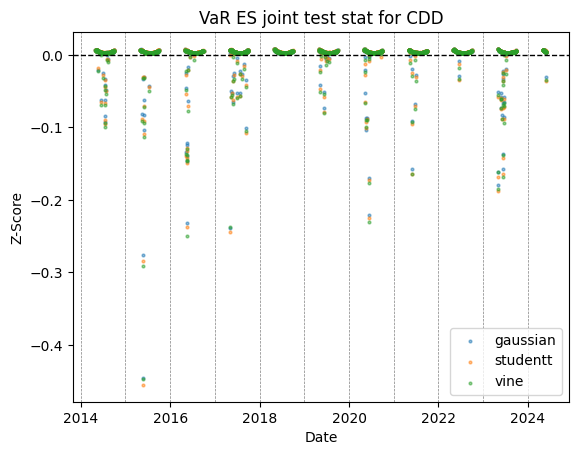

In [ ]:
dct_test_stat = get_joint_test_stat_cv(
    dct_VaR_ES_cv=dct_res_cv_cdd,
    alpha=0.05,
)
df_stat_cdd = pd.DataFrame(dct_test_stat["srs_test_stat"])
# * scatter plot
fig, ax = plt.subplots()
for col in df_stat_cdd.columns:
    ax.scatter(df_stat_cdd.index, df_stat_cdd[col], label=col, s=4, alpha=0.5)
for year in df_stat_cdd.index.year.unique():
    plt.axvline(pd.Timestamp(f"{year}-01-01"), color="gray", lw=0.5, ls="--")
plt.axhline(0, color="black", lw=1, ls="--")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.title("VaR ES joint test stat for CDD")
display(df_stat_cdd.describe())
srs_test_stat = pd.Series(dct_test_stat["test_stat"], name="Z-Score")
srs_test_stat

# HDD scaled res

> assuming equal long weight portfolio
> only days in HDD months


In [5]:
# ! only those days in HDD months
idx_all = df_y.index[df_y.index.month.isin(MONTH_HDD)]
# * CV
gen = get_gen_idx_cv(idx_all=idx_all, num_splits=5)
dct_res_cv_hdd = {}
for idx, (idx_train, idx_test) in enumerate(gen):
    dct_sim = get_sim(df_train=df_res_scaled.loc[idx_train], num_sim=NUM_SIM)
    dct_res_cv_hdd[idx] = get_VaR_ES_portfolio(
        dct_sim=dct_sim,
        df_y_test=df_y.loc[idx_test],
        df_std=df_std,
        df_y_pred=df_y_pred,
        alpha=0.05,
        is_cdd=False,
    )

,gaussian,studentt,vine
count,1603.000000,1603.000000,1603.000000
mean,0.002455,0.002513,0.000431
std,0.010314,0.010244,0.015300
min,-0.144606,-0.143879,-0.178108
25%,0.003508,0.003543,0.002643
50%,0.003851,0.003882,0.002981
75%,0.004259,0.004290,0.003390
max,0.005740,0.005863,0.005120


gaussian    0.633423
studentt    0.644233
vine        0.149864
Name: Z-Score, dtype: float64

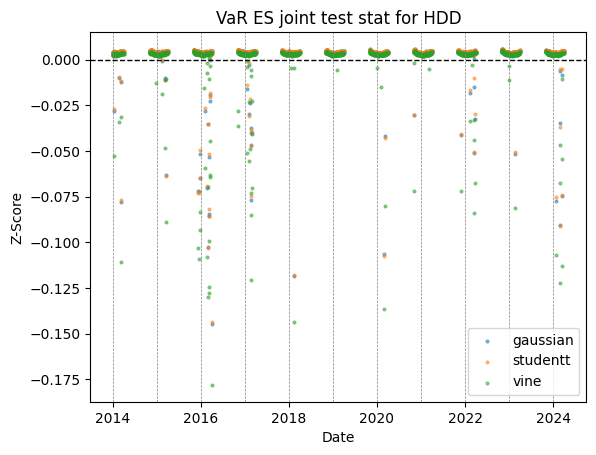

In [6]:
dct_test_stat = get_joint_test_stat_cv(
    dct_VaR_ES_cv=dct_res_cv_hdd,
    alpha=0.05,
)
df_stat_hdd = pd.DataFrame(dct_test_stat["srs_test_stat"])
# * scatter plot
fig, ax = plt.subplots()
for col in df_stat_hdd.columns:
    ax.scatter(df_stat_hdd.index, df_stat_hdd[col], label=col, s=4, alpha=0.5)
for year in df_stat_hdd.index.year.unique():
    plt.axvline(pd.Timestamp(f"{year}-01-01"), color="gray", lw=0.5, ls="--")
plt.axhline(0, color="black", lw=1, ls="--")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.title("VaR ES joint test stat for HDD")
display(df_stat_hdd.describe())
srs_test_stat = pd.Series(dct_test_stat["test_stat"], name="Z-Score")
srs_test_stat